In [1]:
from astropy.io import fits
from astropy.table import Table
import astropy.units as u

import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve

import math as math

import warnings

import scipy.signal as sp

warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
#import fits file

#file_name = "12_21_F0799_EX_SPE_7500573_EXEELONEXEECHL_MRD_0035-0040.fits"
#file_name = "3_1_22_F0832_EX_SPE_7500571_EXEELONEXEECHL_MRD_0089-0091-0092-0093.fits"
#file_name = "3_4_22_F0835_EX_SPE_7500574_EXEELONEXEECHL_MRD_0069-0070-0071-0076.fits"
file_name = "4_27_22_F0860_EX_SPE_7500573_EXEELONEXEECHL_MRD_0058-0061.fits"

hduList = fits.open(file_name)

In [3]:
hduList.info()

Filename: 4_27_22_F0860_EX_SPE_7500573_EXEELONEXEECHL_MRD_0058-0061.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     470   (6879, 4)   float64   


In [4]:
#Size and shape of the original data
hduList[0].data.shape

(4, 6879)

In [5]:
#Diplay first 20 rows of header information
hduList[0].header[0:20]

SIMPLE  =                    T / Written by IDL:  Fri May 13 13:08:54 2022      
BITPIX  =                  -64 / Real*8 (double precision)                      
NAXIS   =                    2 /                                                
NAXIS1  =                 6879 /                                                
NAXIS2  =                    4 /                                                
ADDTIME =              61652.6 /   Effective on-source time                     
AIRSPEED=              487.625 /   knots, aircraft airspeed das.ic1080...       
ALTI_END=              43008.0 /   feet, aircraft altitude end fms.altitude)    
ALTI_STA=              42005.0 /   feet, aircraft altitude start das.ic1080_10hz
AOR_ID  = '75_0057_3'          /   Astronomical Observation Request Identifier  
AOT_ID  = 'UNKNOWN '           /   Astronomical Obervation Template             
ASSC_AOR= '75_0057_3'          /  All input AOR-IDs                             
ASSC_MSN= '2022-04-27_EX_F86

In [6]:
#Import Absorption Table
#absorption_table = Table.read(
#   "H20AbsorptionTable.txt",
#    format="ascii",
#    names=("v", "J", "WL", "El", "A", "gu", "gl", "taudv","tau_uncertainty", "ln(N/gl)", "ln_uncertainty", "Nm/Np"),
#)
#absorption_table[-11:-1]

In [7]:
#Import Hitran Table

hitran = Table.read(
    "4_27_hitran.txt",
    format="ascii",
    names=("Wavenumber", "El", "A","gu","gl","S"),
)
hitran["Wavelength"] = 1 / hitran["Wavenumber"] * 1e4 #convert to wavelength

#Convert from wavenumber to Kelvin
hitran["Eu(cm-1)"] = hitran["El"] + hitran["Wavenumber"]

c = 2.99792458*10**8
h = 6.62607015*10**-34
kb = 1.3806452*10**-23

hitran["Eu(K)"] = hitran["Eu(cm-1)"]*100*h*c/kb

hitran[-101:-1]

Wavenumber,El,A,gu,gl,S,Wavelength,Eu(cm-1),Eu(K)
float64,float64,float64,int32,int32,float64,float64,float64,float64
1483.999399,4695.8364,0.6269,15,15,3.952e-30,6.738547203414332,6179.835799,8891.429326509222
1484.188534,3789.9692,10.84,3,5,1.117e-27,6.737688488300908,5274.157734,7588.357081641454
1484.257225,1899.0082,0.8117,63,69,1.723e-23,6.737376670004083,3383.265425,4867.7774616726
1484.501562,4578.8823,0.1005,15,15,1.118e-30,6.73626775207125,6063.383862000001,8723.880511063648
1484.504774,3659.904,23.41,69,69,1.043e-25,6.7362531769129905,5144.4087739999995,7401.676764307656
1484.714838,661.5489,4.626e-08,13,13,8.295e-29,6.735300102119677,2146.263738,3088.0031384595213
1484.730342,4803.82,12.21,75,75,2.274e-28,6.735229770093834,6288.550342,9047.845727735394
1484.730486,4803.8201,12.2,25,25,7.574e-29,6.735229116862089,6288.550585999999,9047.846078797917
1485.1036,5439.0564,10.33,69,69,8.068e-30,6.73353697344751,6924.16,9962.348723796908


In [8]:
#Load an example HITRAN model for H2O at 300K
water_model = Table.read(
    "for_sean_H2O_1300to1800_300K_5.0e18_6kms.txt",
    format="ascii",
    names=("wavenumber", "flux"),
)

#Inspect water model
water_model[0:20]

#Create new variables for wavelength in um
water_model["wavelength_um"] = 1 / water_model["wavenumber"] * 1e4 #convert water model units too

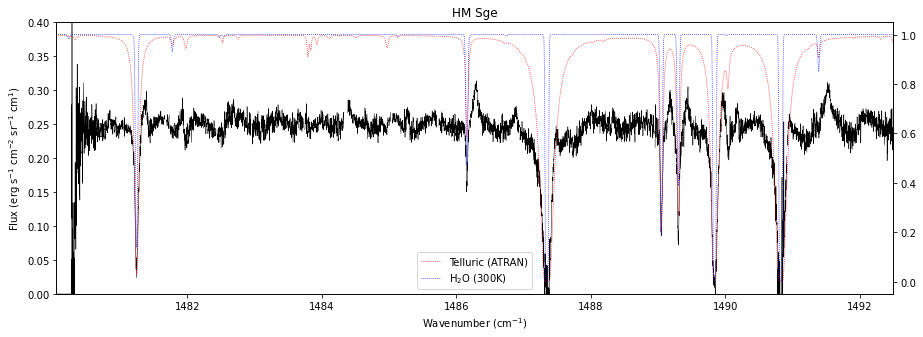

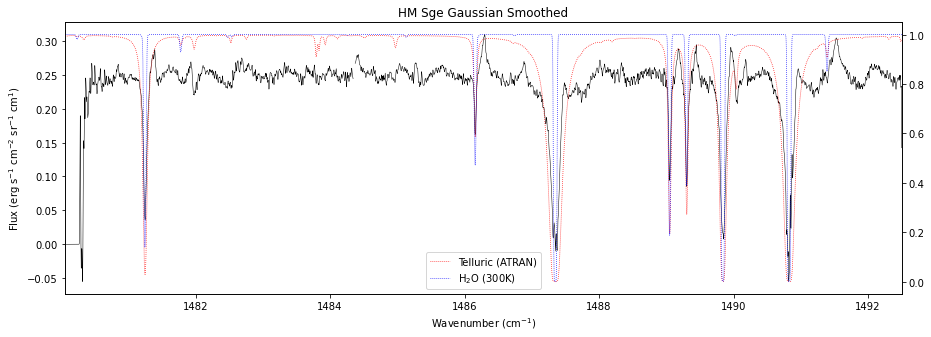

In [9]:
#Original Plot

#Data columns to variables with units
wavenumber = hduList[0].data[0].view()
flux_unit = u.erg * u.s ** (-1) * (u.cm) ** -2 * u.sr ** (-1)
flux = hduList[0].data[1].view()
original_flux = flux.view() * flux_unit
uncertainty = hduList[0].data[2].view() * flux_unit
atran = hduList[0].data[3].view()

#Gaussian smooth the data to visually highlight peaks
standardDeviation = 2
g = Gaussian1DKernel(stddev=standardDeviation)
gauss_flux = convolve(flux, g)

#Plot the whole spectrum
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(wavenumber,  flux, lw=0.5, c="k")
ax2.plot(wavenumber, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)")
ax2.plot(
        water_model["wavenumber"],
        water_model["flux"],
        lw=0.75,
        c="b",
        linestyle=":",
        label=r"H$_2$O (300K)",
    )
ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ cm$^{1}$)")
ax1.set_xlabel(r"Wavenumber (cm$^{-1}$)")
ax1.set_xlim(min(wavenumber), max(wavenumber))
ax1.set_ylim(0,.4)
plt.legend()
plt.title("HM Sge")
plt.show()

#Plot the smoothed version
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(wavenumber,  gauss_flux, lw=0.5, c="k")
ax2.plot(wavenumber, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)")
ax2.plot(
        water_model["wavenumber"],
        water_model["flux"],
        lw=0.75,
        c="b",
        linestyle=":",
        label=r"H$_2$O (300K)",
    )
ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ cm$^{1}$)")
ax1.set_xlabel(r"Wavenumber (cm$^{-1}$)")
ax1.set_xlim(min(wavenumber), max(wavenumber))
plt.legend()
plt.title("HM Sge Gaussian Smoothed")
plt.show()

In [10]:
#Function to set up the plots

#Convert wavenumber to wavelength
wavelength_um = 1 / wavenumber * 1e4  #convert wavenumber (cm^-1) to wavelength in um

#correction velocity
v_corrected = 13.21 #from exes velocity shift program

#correct for system velocities in the graph
watergraph = water_model["wavelength_um"]*(v_corrected/300000) + water_model["wavelength_um"]
#watergraph = water_model["wavelength_um"]

#Flux smoothing
flux = gauss_flux

def plot_window(xmin, xmax):
    #Create axes
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 1, 1)
    #create second axis to overplot ATRAN
    ax2 = ax1.twinx()
    #hide axis labels and ticks
    ax2.set_yticks([])
    #plot data
    ax1.plot(wavelength_um, flux, lw=0.5, c="k")
    #plot Atmospheric model (ATRAN)
    ax2.plot(
        wavelength_um, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)"
    )

    #Setup water model plot
    ax2.plot(
        water_model["wavelength_um"],
        water_model["flux"],
        lw=0.75,
        c="b",
        linestyle=":",
        label=r"H$_2$O (300K)",
    )

    #Plot labels
    ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ cm$^{1}$)")
    ax1.set_xlabel(r"Wavelength ($\mu$m)")

    ax1.set_xlim(xmin, xmax)

    plt.legend(loc="lower right")
    plt.title("HM Sge 4-27-22")
    return fig, ax1, ax2

#Min and max flux
print(min(flux))
print(max(flux))

-0.05508729065211332
0.3092298089651788


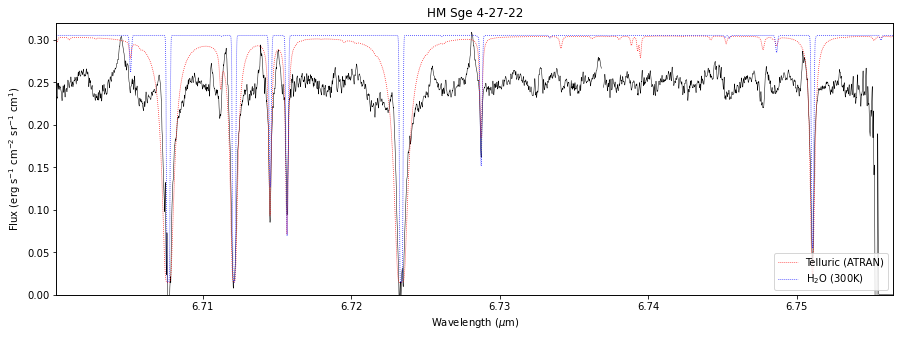

In [11]:
#Plot the full spectrum
minW = min(wavelength_um)
maxW = max(wavelength_um)

#Calls the previously created plot_window function and plots the full range of the data set
fig, ax1, ax2 = plot_window(minW, maxW) 

#Optional manual y range
ax1.set_ylim(0, .32) 

plt.show()

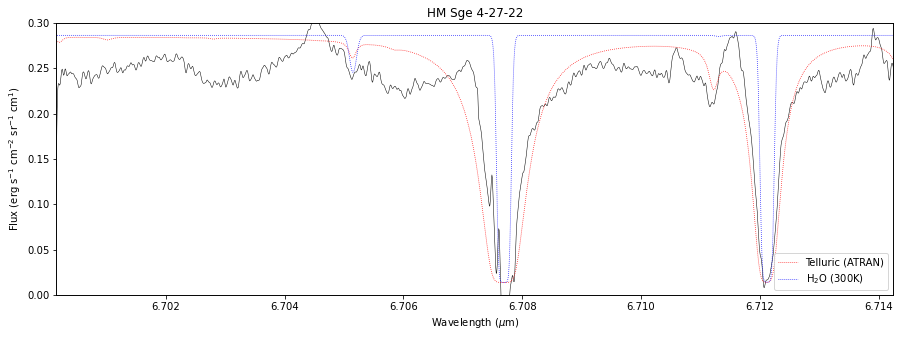

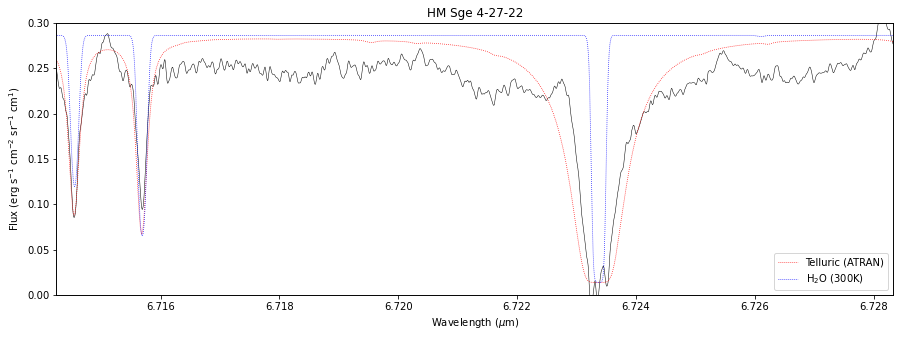

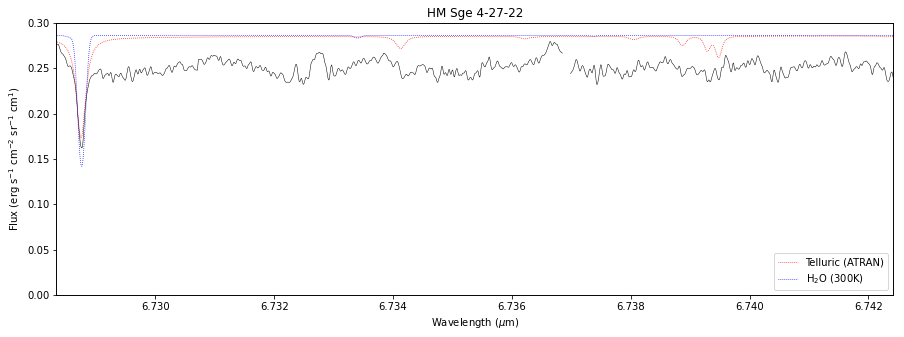

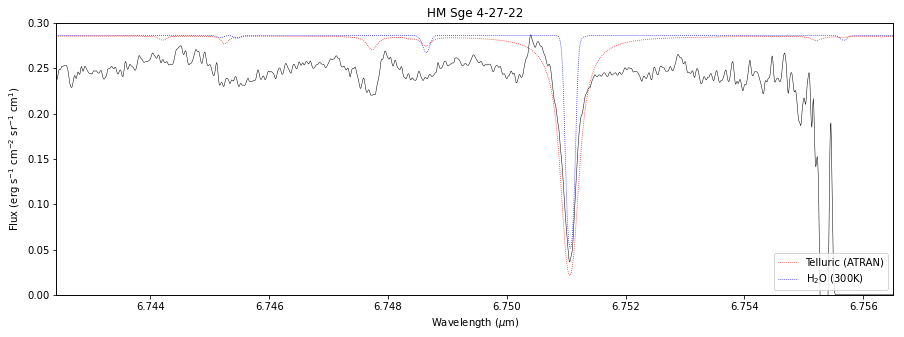

In [12]:
#Zoom in on m divisions of the spectrum

m = 4 #number of seperate plots
j = 0 #indexing value
frac = (maxW - minW)/m #width of each plot
while j < m:
    fig, ax1, ax2 = plot_window(minW + j*frac, minW + (j+1)*frac)
    ax1.set_ylim(0, .3) 
    plt.show()
    j+=1

In [13]:
#Identify Emission Peaks

fluxPeakIndices, _ = sp.find_peaks(flux, height=.23, distance = 90)
#print(fluxPeakIndices)

fluxPeakWavelengths = wavelength_um[fluxPeakIndices]
print(fluxPeakWavelengths)

examplePeakWavelength = []

#Find notable features and programmatically determine their values
examplePeakWavelength.append(wavelength_um[fluxPeakIndices[-6]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[-27]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[4]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[-9]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[-12]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[-15]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[-14]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[7]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[-23]])

examplePeakWavelength.sort()

exampleIndicies = []
examplePeakValues = []
print("Wavelengths of Peaks in Order:", examplePeakWavelength)

for x in examplePeakWavelength:
    exampleIndicies.append(np.where(wavelength_um == x))

for x in exampleIndicies:
    examplePeakValues.append(flux[x][0])

print("Heights of Peaks in Order:", examplePeakValues)

[6.75467367 6.75380326 6.75287908 6.75199189 6.75040453 6.74944403
 6.74870506 6.74794959 6.74712759 6.74628246 6.74543755 6.7445101
 6.74358347 6.7425744  6.74161501 6.74084559 6.73959947 6.73857773
 6.73761893 6.73664377 6.73561518 6.73482055 6.73384565 6.73276203
 6.73176284 6.73098515 6.73023198 6.72906826 6.72811879 6.72726737
 6.72638357 6.72547572 6.72275362 6.72196037 6.7211673  6.72036836
 6.7189303  6.7175529  6.71670304 6.71591892 6.71511022 6.71390661
 6.71299221 6.7115958  6.71059848 6.70946407 6.70707285 6.70619985
 6.70542641 6.70453737 6.70378681 6.70297993 6.70218092 6.70113761
 6.70031437]
Wavelengths of Peaks in Order: [6.704537372598854, 6.707072850666433, 6.711595797420246, 6.713906605231799, 6.71511021936983, 6.722753624127989, 6.7281187894051175, 6.747949585436027, 6.750404533977764]
Heights of Peaks in Order: [0.30426134860725157, 0.2588055050122121, 0.29039464909322693, 0.29421350680848596, 0.2882333490789794, 0.2381599821968781, 0.3092298089651788, 0.268930361

In [14]:
#Identify troughs in the unshifted water model
water_model = np.transpose(water_model)

#print(water_model)
water = (-1*water_model["flux"])+1
#print(water)
waterTroughIndices, _ = sp.find_peaks(water, height = .05,distance = 50)
#print(waterTroughIndices)
waterTroughFlux = water[waterTroughIndices]
#print(waterTroughFlux)
waterPeakWavelength = water_model["wavelength_um"][waterTroughIndices]
#print(waterPeakWavelength)

exampleWaterWL=[]
#Find notable features and programmatically determine their values
for wl in waterPeakWavelength:
    if((wl> 6.704) & (wl < 6.706)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 6.728) & (wl < 6.730)):
        exampleWaterWL.append(wl)
        break  

for wl in waterPeakWavelength:
    if((wl> 6.750) & (wl < 6.752)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 6.706) & (wl < 6.708)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 6.711) & (wl < 6.713)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 6.7156) & (wl < 6.716)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 6.714) & (wl < 6.715)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 6.748) & (wl < 6.750)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 6.722) & (wl < 6.724)):
        exampleWaterWL.append(wl)
        break

exampleWaterWL.sort()

exampleWaterIndicies = []
waterTroughVals = []

for x in exampleWaterWL:
    exampleWaterIndicies.append([np.where(water_model["wavelength_um"] == x)])

print(exampleWaterWL)

[6.705157498121694, 6.707696753347325, 6.712124566088499, 6.714551801709945, 6.715689805382479, 6.723372604198616, 6.728763391578174, 6.7486472265773525, 6.75106537600672]


In [15]:
#Velocity calculation

#correction velocity
v_corrected = -28.300809 #from exes velocity shift program

#convert to m
fluxPeakWL = [EmissionWL * 10**-6 for EmissionWL in examplePeakWavelength]
waterTroughWL = [WaterWL *10**-6 for WaterWL in exampleWaterWL]

#difference of each water trough and flux peak
diff = list()
for w1, w2 in zip(fluxPeakWL, waterTroughWL):
    diff.append(w1-w2)

#velocity calculation
c = 3*(10**8)
totV = []
i = 0
while i < len(diff):
    totV.append(((diff[i]/waterTroughWL[i]) * c) /1000) #convert to km/s
    i+=1

correctedV = [x - v_corrected for x in totV]

print("Corrected velocities of lines = ",correctedV, "km/s")

Corrected velocities of lines =  [0.5553523266648952, 0.39692318790813985, 4.667367916792948, -0.5259763402548217, 2.409827011041198, 0.6816315246865656, -0.4385953546032084, -2.7116791877834103, -1.0653128852295026] km/s


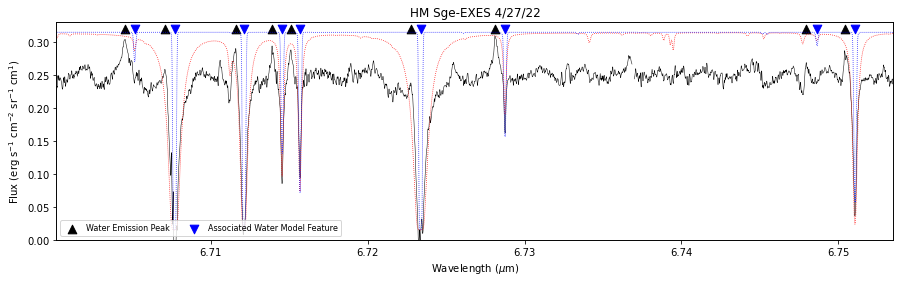

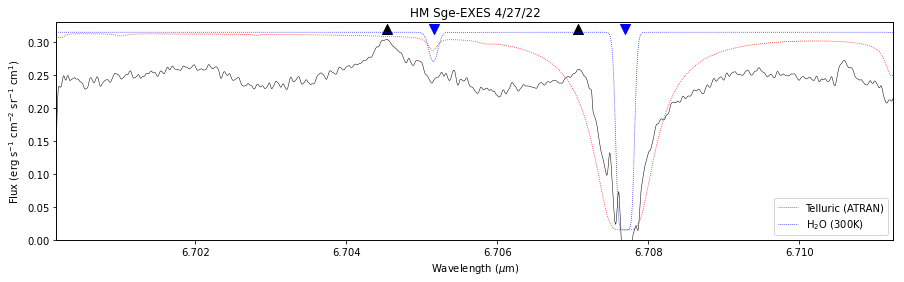

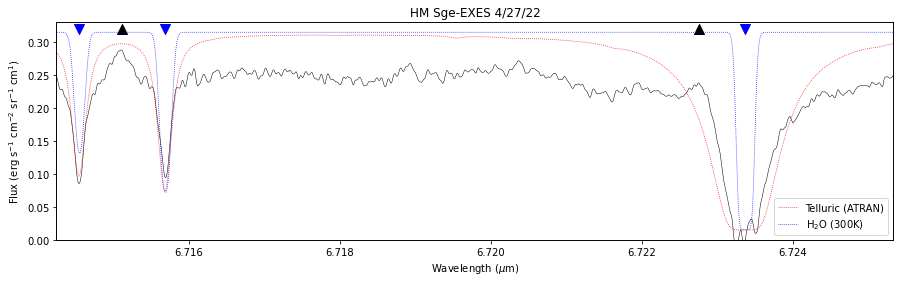

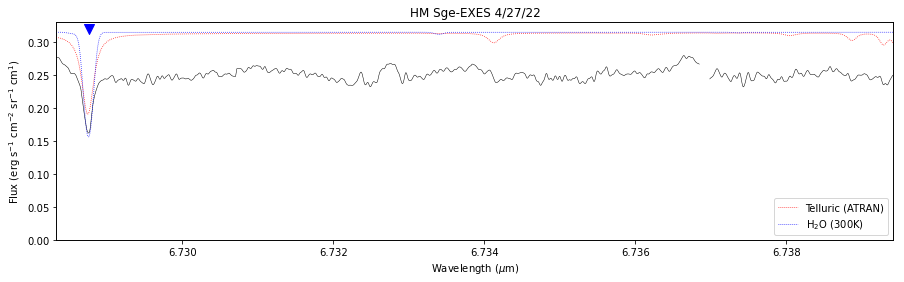

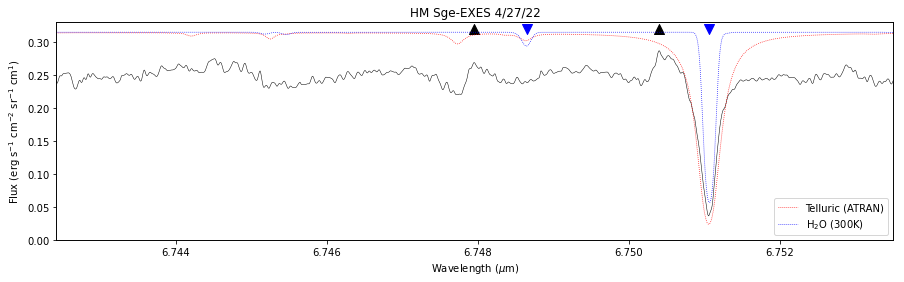

In [16]:
#correct for system/observation velocities by shifting the water model or don't

#watergraph = water_model["wavelength_um"]*(v_corrected/300000) + water_model["wavelength_um"]
watergraph = water_model["wavelength_um"]

#Visual flux smoothing (calculations done with origional data)
flux = gauss_flux

def plot_window(xmin, xmax):
    #Create axes
    fig = plt.figure(figsize=(15, 4))
    ax1 = fig.add_subplot(1, 1, 1)
    #create second axis to overplot ATRAN
    ax2 = ax1.twinx()
    #hide axis labels and ticks
    ax2.set_yticks([])
    #plot data
    ax1.plot(wavelength_um, flux, lw=0.5, c="k")
    #plot Atmospheric model (ATRAN)
    ax2.plot(
        wavelength_um, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)"
    )

    #Setup water model plot
    ax2.plot(
        watergraph,
        water_model["flux"],
        lw=0.75,
        c="b",
        linestyle=":",
        label=r"H$_2$O (300K)",
    )

    #Plot labels
    ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ cm$^{1}$)")
    ax1.set_xlabel(r"Wavelength ($\mu$m)")

    ax1.set_xlim(xmin, xmax-.003)

    plt.legend(loc="lower right")
    plt.title("HM Sge-EXES 4/27/22")
    return fig, ax1, ax2

#Calls the previously created plot_window function and plots the full range of the data set
fig, ax1, ax2 = plot_window(minW, maxW) 

#Optional manual y range
ax1.set_ylim(0, .33) 

#marks the features on the plot
pointers = np.full(len(examplePeakWavelength),.32)

emission = ax1.scatter(examplePeakWavelength, pointers, s=75, c = "black", marker = "^")
trough = ax1.scatter(exampleWaterWL, pointers, s=75, c = "blue", marker = "v")

plt.legend((emission, trough),
           ('Water Emission Peak', "Associated Water Model Feature"),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

plt.show()

#Zoom in on m divisions of the spectrum

m = 4 #number of seperate plots
j = 0 #indexing value
frac = (maxW - minW)/m #width of each plot
while j < m:
    fig, ax1, ax2 = plot_window(minW + j*frac, minW + (j+1)*frac)
    ax1.set_ylim(0, .33) 
    pointers = np.full(len(examplePeakWavelength),.32)
    scatter = ax1.scatter(examplePeakWavelength, pointers, s=100, c = "black", marker = "^")
    scatter = ax1.scatter(exampleWaterWL, pointers, s=100, c= "blue",marker = "v")
    
    plt.show()
    j+=1

[0.06705157 0.06707697 0.06712125 0.06714552 0.0671569  0.06723373
 0.06728763 0.06748647 0.06751065]
[138.94998452210905, 140.8431277919671, 140.0533381360463, 140.98827508886964, 139.32743107578372, 141.3753695926754, 139.2591091605352, 141.10944263511234, 141.3962816023558]
[4420.979927951226, 2614.91399850185, 2939.0744016207937, 3268.4960176487234, 3589.996779715872, 2436.7910575264696, 3867.557894396133, 3977.7937139890482, 2912.312114060098]
[-9.75371671e-04  1.43621193e+02]
1025.2501991095983


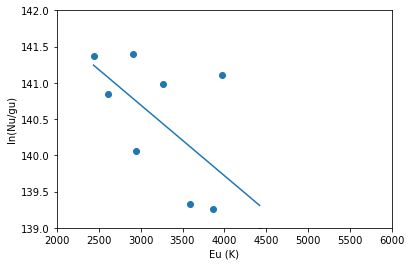

In [17]:
#Use hitran to make rotational diagrams

#Match the water model wavelengths to specific entries in the hitran table
tableWLs = []
for w in exampleWaterWL:
    tableWLs.append((min(hitran["Wavelength"], key=lambda x:abs(x-w))))

#print(tableWLs)

#find the indicies of those entries
tableIndicies = []
for x in tableWLs:
    tableIndicies.append(np.where(hitran["Wavelength"] == x)[0][0])

#print(tableIndicies)

waterWavelengthMeters =  np.dot(1/100,exampleWaterWL)
print(waterWavelengthMeters)

#Calculate the # of emitting molecules (Nu)
Nu = []
d = 3.2166*10**19 #distance (m)
i = 0
for x in tableIndicies:
    num = 4*math.pi*examplePeakValues[i]*(d**2)*waterWavelengthMeters[i]
    den = 3*(10**8)*hitran["A"][x]*6.62607015*(10**(-34))
    Nu.append(num/den)
    i=i+1

#Retrieve upper degeneracy from hitran
gu = []
for x in tableIndicies:
    gu.append(hitran["gu"][x])

#Retrieve upper energy from hitran
Eu = []
for x in tableIndicies:
    Eu.append(hitran["Eu(K)"][x])

#print(Nu)
#print(gu)

#Calculate the number of emitting molecules over the upper state degeneracy
numDegen = []
j = 0
for x in Nu:
    z = Nu[j]/gu[j]
    numDegen.append(math.log(z))
    j=j+1

print(numDegen)
print(Eu)

x = Eu
y = numDegen
plt.scatter(x, y)
plt.ylabel("ln(Nu/gu)")
plt.xlabel("Eu (K)")
plt.xlim([2000, 6000])
plt.ylim([139,142])

#fit a line to the data to find temperature
mb = np.polyfit(x, y, 1)
print(mb)
m = -1/mb[0]
print(m)
plt.plot(np.unique(x), np.poly1d(mb)(np.unique(x)))

plt.show()

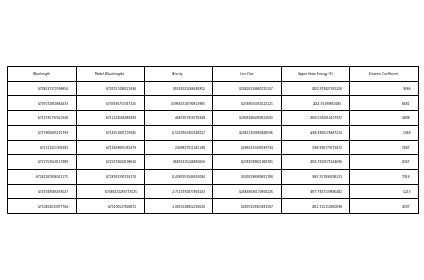

In [18]:
#Tabulated values to include with paper

#define figure and axes
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

#obDate = ["4/27/22", "","","",]

A = []
for x in tableIndicies:
    A.append(hitran["A"][x])
#create data
df = pd.DataFrame(np.transpose([examplePeakWavelength,  exampleWaterWL, correctedV, examplePeakValues, Eu, A]), columns=["Wavelength", "Model Wavelengths", "Velocity", "Line Flux", "Upper State Energy (K)", "Einstein Coefficient"])

#create table
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

#display table
fig.tight_layout()
plt.show()

df.to_csv('4_27.csv')